<a href="https://colab.research.google.com/github/deepskandpal/hands-on-machine-learning/blob/POC/Newyork_taxi_ETA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"atdeepanshu","key":"efb7cfbda38df5a60eec6e85835e4859"}'}

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [ ]:
!kaggle competitions download -c nyc-taxi-trip-duration


test.zip: Skipping, found more recently modified local copy (use --force to force download)
train.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!ls

'kaggle (1).json'   sample_data		    test.zip
 kaggle.json	    sample_submission.zip   train.zip


In [ ]:
train_data = pd.read_csv("train.zip")
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


## Explorately Data Analysis

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [ ]:
train_data.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [ ]:
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
geolocator = Nominatim(user_agent="my_app")
location = geolocator.reverse("40.767937, -73.982155")
location1 = (40.767937, -73.982155)
location2 = (40.765602, -73.964630)
addr1 = geolocator.reverse("40.767937, -73.982155")
addr2 = geolocator.reverse("40.765602, -73.964630")
print("addr1 =", addr1.address)
print("addr2 = ", addr2.address)
print(geodesic(location1, location2).m) 



addr1 = Columbus Circle, Manhattan Community Board 4, Manhattan, New York County, New York, United States of America
addr2 =  146, East 65th Street, Lenox Hill, Manhattan Community Board 8, Manhattan, New York County, New York, 10065, United States of America
1502.2029520818444


In [ ]:
def get_distance_in_metre(df):
  start_point = (df["pickup_latitude"], df["pickup_longitude"])
  drop_point = (df["dropoff_latitude"], df["dropoff_longitude"])
  total_distance = geodesic(start_point, drop_point).m
  return total_distance

In [ ]:
train_data['distance'] = train_data.apply(get_distance_in_metre, axis = 1) 

In [64]:
train_data_cpy = train_data.drop(["dropoff_longitude", "dropoff_latitude", "pickup_latitude", "pickup_longitude"], axis=1)

In [ ]:
train_data_cpy

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,store_and_fwd_flag,trip_duration,distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,N,455,1502.171837
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,N,663,1808.659969
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,N,2124,6379.687175
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,N,429,1483.632481
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,N,435,1187.037659
...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,N,778,1227.089623
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,N,655,6046.211843
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,N,764,7821.531849
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,N,373,1092.524008


In [61]:
train_data_cpy = train_data_cpy.round({"trip_duration":2, "distance":2}) 

train_data_cpy.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,store_and_fwd_flag,trip_duration,distance
0,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,N,455,1502.17
1,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,N,663,1808.66
2,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,N,2124,6379.69
3,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,N,429,1483.63
4,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,N,435,1187.04


In [60]:
from scipy import stats
print(train_data_cpy.distance.max()) 
print(train_data_cpy.trip_duration.max()) 
print(stats.trim_mean(train_data_cpy.trip_duration, 0.1))
print(stats.trim_mean(train_data_cpy.distance, 0.1))
#print(train_data_cpy.mean(axis = 0))
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
trip_duration = train_data_cpy.trip_duration.values.reshape(-1, 1)
distance = train_data_cpy.distance.values.reshape(-1,1)
train_data_cpy_trip_duration_scaled = min_max_scaler.fit_transform(trip_duration)
train_data_cpy_distance_scaled = min_max_scaler.fit_transform(distance)
print(train_data_cpy_trip_duration_scaled)

1240510.26
3526282
734.4517900174477
2578.768343076966
[[1.28747539e-04]
 [1.87733195e-04]
 [6.02050716e-04]
 ...
 [2.16375269e-04]
 [1.05493578e-04]
 [5.58662228e-05]]


In [48]:
train_data[train_data.trip_duration == train_data.trip_duration.max()]
train_data_cpy[train_data_cpy.distance == train_data_cpy.distance.max()]

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,store_and_fwd_flag,trip_duration,distance
184925,1,2016-05-07 18:58:53,2016-05-07 19:12:05,1,N,792,1240510.26


In [65]:
def pandas_profile(df):
    print(train_data.describe())
    print(train_data.info())
    from pandas_profiling import ProfileReport
    prof = ProfileReport(df)
    prof.to_file(output_file='report.html')

In [69]:
train_data_cpy.to_csv("train_data_cpy.csv", index=False)

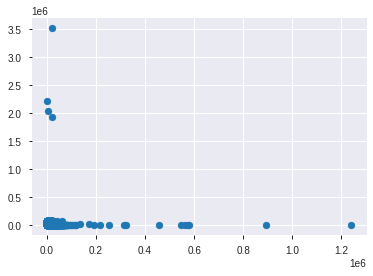

In [77]:
plt.scatter(train_data_cpy['distance'],train_data_cpy['trip_duration'])


In [ ]:
train_data_cpy['pickup_datetime'] = pd.to_datetime(train_data_cpy['pickup_datetime'])
train_data_cpy['dropoff_datetime'] = pd.to_datetime(train_data_cpy['dropoff_datetime'])

In [ ]:
def datetime_to_float(d):
    return d.timestamp()
temp = train_data_cpy['pickup_datetime'].apply(datetime_to_float)

In [ ]:
train_data_cpy = train_data_cpy.drop(['id'], axis=1)

In [ ]:
def datetime_to_float(d):
    return d.timestamp()

def normalize_numeric_data(data):
    y = data['trip_duration']
    y_train = np.asarray(y).astype('float32')
    data = data.drop(['trip_duration'], axis=1)
    date_time = data.select_dtypes(include=['datetime64'])
    for column in date_time:
        date_time[column] = date_time[column].apply(datetime_to_float)
    numeric_data = data.select_dtypes(include=[np.number])
    from sklearn import preprocessing
    x = numeric_data.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df = pd.DataFrame(x_scaled)
    df_col = pd.concat([date_time,df], axis=1)
    #np_reader = tf.contrib.timeseries.NumpyReader(data={tf.contrib.timeseries.TrainEvalFeatures.TIMES: data['timestamp'].values, tf.contrib.timeseries.TrainEvalFeatures.VALUES : data['value'].values})
    X = df_col.to_numpy()
    #X = np.asarray(X).astype(np.float32)
    return X, y_train

In [ ]:
X, y = normalize_numeric_data(train_data)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [ ]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential() 
    model.add(layers.Dense(512, activation='selu', input_shape=(X_train.shape[1],))) 
    model.add(layers.Dropout(rate=0.5))
    model.add(layers.Dense(512, activation='selu'))
    model.add(layers.Dropout(rate=0.5))
    model.add(layers.Dense(512, activation='selu'))
    model.add(layers.Dropout(rate=0.5))
    model.add(layers.Dense(512, activation='selu'))
    model.add(layers.Dropout(rate=0.5))
    model.add(layers.Dense(512, activation='selu'))
    model.add(layers.Dropout(rate=0.5))
    model.add(layers.Dense(512, activation='selu'))
    model.add(layers.Dropout(rate=0.5))
    model.add(layers.Dense(512, activation='selu'))
    model.add(layers.Dropout(rate=0.5))
    model.add(layers.Dense(256, activation='selu'))
    model.add(layers.Dropout(rate=0.5))
    model.add(layers.Dense(256, activation='selu'))
    model.add(layers.Dropout(rate=0.5))
    model.add(layers.Dense(256, activation='selu'))
    model.add(layers.Dropout(rate=0.5))
    model.add(layers.Dense(128, activation='selu'))
    model.add(layers.Dropout(rate=0.5))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mean_squared_logarithmic_error', metrics=['acc']) 
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=20, batch_size=12, verbose=2)
    return history

In [33]:
history = build_model()


Epoch 1/20
81441/81441 - 2005s - loss: 41.1914 - acc: 1.0232e-06 - val_loss: 42.4435 - val_acc: 0.0000e+00
Epoch 2/20
81441/81441 - 1949s - loss: 42.4606 - acc: 0.0000e+00 - val_loss: 42.4435 - val_acc: 0.0000e+00
Epoch 3/20
81441/81441 - 1938s - loss: 42.4608 - acc: 0.0000e+00 - val_loss: 42.4435 - val_acc: 0.0000e+00
Epoch 4/20


KeyboardInterrupt: ignored